In [1]:
# import necessary libraries
import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns
import math
import re
import time
import os
import sys
import csv
import string
import warnings
warnings.filterwarnings('ignore') 

import statsmodels.formula.api as sm

from sklearn import tree, svm, metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RepeatedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)

pd.set_option("display.max_rows", 100, "display.max_columns", 100)

Here we will do actual analysis. Since we have already converted the dataframes to csv files, we won't have to run all the web-scraping algorithms.

In [2]:
all_nba_players = pd.read_csv('csv_files/all_nba_players.csv')

In [3]:
# display(all_nba_players)
# display(all_nba_players.dtypes)

In [4]:
display(all_nba_players.describe())

,Debut,Last Active,YOE,Retired,Total Games,Career PPG,Total PTS,Career RPG,Total RBS,Career APG,Total AST,Career SPG,Total STL,Career BPG,Total BLK,Career FG%,Career FG3%,Career FT%,Career eFG%,PER,Avg WS,Total WS,Hall of Fame,Year Inducted,All-Stars,Scoring Champs,Rebound Champs,Assist Champs,Steal Champs,Block Champs,NBA Champs,All-NBA,All-Rookie,ROY,All-Defensive,Most Improved,Sixth Man,AS MVPs,DPOYs,MVPs,Finals MVPs,NBA 75th Anniv. Team
count,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.00000,4397.000000,4397.000000,4397.000000
mean,1991.204003,1996.766432,5.268820,0.807824,290.551740,6.455788,2992.915624,2.942188,1291.967478,1.456902,667.068228,0.459177,196.698658,0.269343,122.587901,41.443484,17.307619,67.131385,36.414373,11.044485,1.508710,14.771139,0.029566,58.657721,0.411417,0.017057,0.016375,0.016602,0.010917,0.010917,0.209234,0.203775,0.112349,0.019331,0.126450,0.008187,0.008870,0.017967,0.00887,0.016830,0.012054,0.017285
std,20.994117,21.249146,4.500436,0.394056,320.393188,4.823565,4725.649713,2.276650,2129.285266,1.392988,1213.283236,0.414007,336.844494,0.368878,291.804208,10.820365,17.165869,20.159278,20.840834,6.664832,2.081922,27.272577,0.169405,337.447671,1.663636,0.254049,0.269305,0.270555,0.157809,0.168947,0.717566,1.171334,0.315832,0.137702,0.834822,0.090123,0.113524,0.180725,0.14040,0.217916,0.169542,0.130344
min,1946.000000,1950.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-48.600000,-2.000000,-10.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,1976.000000,1982.000000,1.000000,1.000000,34.000000,2.900000,97.000000,1.300000,42.000000,0.500000,19.000000,0.100000,2.000000,0.000000,0.000000,37.600000,0.000000,62.300000,30.000000,8.700000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,1993.000000,2000.000000,3.000000,1.000000,143.000000,5.200000,761.000000,2.400000,351.000000,1.000000,152.000000,0.400000,36.000000,0.200000,15.000000,42.700000,17.600000,71.800000,45.300000,11.600000,0.700000,2.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,2010.000000,2016.000000,8.000000,1.000000,490.000000,8.700000,3948.000000,3.900000,1713.000000,2.000000,752.000000,0.700000,250.000000,0.400000,110.000000,46.900000,32.700000,78.400000,49.800000,14.200000,2.400000,17.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,2021.000000,2022.000000,22.000000,1.000000,1611.000000,30.100000,38387.000000,22.900000,23924.000000,11.200000,15806.000000,2.700000,3265.000000,3.500000,3830.000000,100.000000,100.000000,100.000000,150.000000,88.300000,17.900000,273.400000,1.000000,2022.000000,19.000000,10.000000,11.000000,9.000000,6.000000,4.000000,11.000000,17.000000,1.000000,1.000000,15.000000,1.000000,3.000000,4.000000,4.00000,6.000000,6.000000,1.000000


In [5]:
retired_csv = pd.read_csv('csv_files/retired_players.csv')

In [6]:
# we'll only want to train and look at data from those who are officially elligible to enter -- retired at least 4 years
retired_hof_eligible = retired_csv[retired_csv['Last Active'] <= 2018].dropna();

In [7]:
hof_players = pd.read_csv('csv_files/hall_of_famers.csv')

In [8]:
hof_players.describe()

,Debut,Last Active,YOE,Retired,Total Games,Career PPG,Total PTS,Career RPG,Total RBS,Career APG,Total AST,Career SPG,Total STL,Career BPG,Total BLK,Career FG%,Career FG3%,Career FT%,Career eFG%,PER,Avg WS,Total WS,Hall of Fame,Year Inducted,All-Stars,Scoring Champs,Rebound Champs,Assist Champs,Steal Champs,Block Champs,NBA Champs,All-NBA,All-Rookie,ROY,All-Defensive,Most Improved,Sixth Man,AS MVPs,DPOYs,MVPs,Finals MVPs,NBA 75th Anniv. Team
count,130.000000,130.000000,130.000000,130.0,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.0,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,1970.807692,1984.461538,13.323077,1.0,930.823077,18.253077,17215.707692,7.743846,7079.669231,3.862308,3671.153846,0.876923,745.069231,0.626154,570.176923,46.505385,14.721538,76.660000,31.221538,19.281538,7.689231,104.695385,1.0,1983.984615,7.538462,0.461538,0.400000,0.369231,0.100000,0.115385,1.676923,4.523077,0.538462,0.276923,1.853846,0.007692,0.038462,0.469231,0.153846,0.461538,0.292308,0.484615
std,15.446881,17.638996,3.322965,0.0,265.040774,4.575824,7096.014110,3.994143,4402.044790,1.995975,2422.608599,0.688503,754.790275,0.768322,855.176816,5.049819,15.264825,7.673811,24.516089,3.218787,2.596546,48.547574,0.0,176.093482,3.662409,1.306833,1.378686,1.376088,0.463388,0.551736,2.164604,3.943821,0.500447,0.449209,3.362150,0.087706,0.229723,0.827703,0.615832,1.086591,0.811221,0.501697
min,1946.000000,1954.000000,3.000000,1.0,202.000000,5.700000,3315.000000,1.900000,980.000000,1.000000,587.000000,0.000000,0.000000,0.000000,0.000000,30.200000,0.000000,41.400000,0.000000,10.900000,2.200000,16.100000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1958.000000,1971.250000,11.000000,1.0,766.250000,15.600000,12006.000000,4.400000,3832.250000,2.500000,2057.250000,0.000000,0.000000,0.000000,0.000000,43.650000,0.000000,73.700000,0.000000,17.300000,5.925000,74.925000,1.0,1987.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1970.000000,1983.000000,13.000000,1.0,912.500000,18.500000,16984.500000,6.750000,5727.000000,3.450000,3038.000000,1.000000,603.500000,0.300000,200.000000,46.500000,14.300000,78.000000,46.850000,18.950000,7.150000,93.300000,1.0,1999.500000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1983.750000,1999.000000,15.000000,1.0,1073.750000,20.775000,21739.750000,10.250000,9345.500000,4.700000,4594.000000,1.300000,1208.000000,0.800000,750.250000,50.375000,27.475000,80.925000,50.700000,21.350000,8.875000,129.925000,1.0,2014.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,7.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,2003.000000,2018.000000,21.000000,1.0,1611.000000,30.100000,38387.000000,22.900000,23924.000000,11.200000,15806.000000,2.600000,3265.000000,3.100000,3830.000000,58.200000,66.700000,90.400000,58.200000,27.900000,17.700000,273.400000,1.0,2022.000000,19.000000,10.000000,11.000000,9.000000,3.000000,4.000000,11.000000,15.000000,1.000000,1.000000,15.000000,1.000000,2.000000,4.000000,4.000000,6.000000,6.000000,1.000000


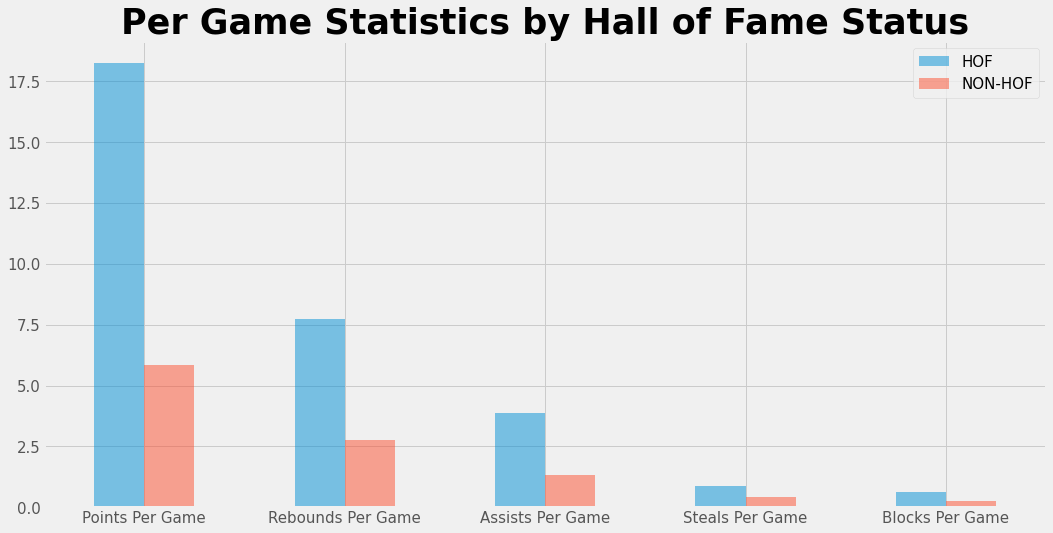

<Figure size 720x432 with 0 Axes>

In [9]:
plt.style.use('fivethirtyeight')

sort_by_hof = retired_hof_eligible.groupby('Hall of Fame')['Career PPG','Career RPG',
                                                           'Career APG','Career SPG','Career BPG']
sort_by_hof = sort_by_hof.mean().transpose()  # average stats, transposed for graphing purposes
sort_by_hof = sort_by_hof.rename({'Career PPG': 'Points Per Game', 
                                  'Career RPG': 'Rebounds Per Game', 
                                  'Career APG': 'Assists Per Game',
                                   'Career SPG': 'Steals Per Game',
                                    'Career BPG': 'Blocks Per Game'},
                                   axis='index')
sort_by_hof = sort_by_hof.rename({1:'HOF', 0:'NON-HOF'}, axis='columns')

sort_by_hof = sort_by_hof[sort_by_hof.columns[::-1]] # reverse column order
sort_by_hof.plot(kind='bar', figsize=(16,8), alpha=0.5, rot=0)

plt.legend(prop={'size':15}, frameon=True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title('Per Game Statistics by Hall of Fame Status', fontsize=35, fontweight="bold")
plt.show()

plt.savefig('images/hof_stats.png')

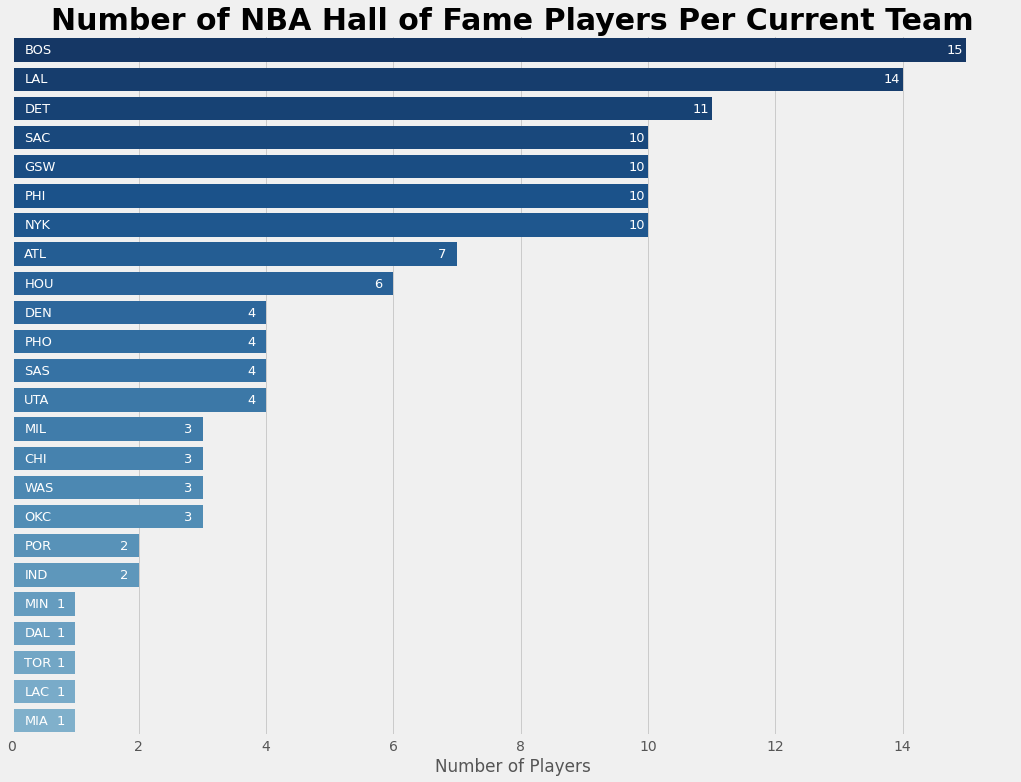

<Figure size 720x432 with 0 Axes>

In [10]:
plt.style.use('fivethirtyeight')

num_teams = hof_players['Team'].value_counts()[:30]
hof_num_teams = pd.DataFrame(num_teams)
hof_num_teams.columns = ['Number of Players']

plt.figure(figsize=(16,12))
sns.barplot(x='Number of Players', y=hof_num_teams.index, data=hof_num_teams, 
            palette=sns.color_palette("Blues_r", 45))
plt.title('Number of NBA Hall of Fame Players Per Current Team', fontsize=30, fontweight="bold")
plt.gca().set_yticks([]);

for num in range(len(num_teams)):
    plt.text(num_teams[num]-0.3, num, num_teams[num], color='white', size=13, verticalalignment='center')
    plt.text(0.2, num, num_teams.index[num], color='white', size=13, verticalalignment='center')
plt.show()

plt.savefig('images/hof_per_team.png')

In [11]:
retired_non_hof_csv = pd.read_csv('csv_files/retired_non_hof.csv')

In [12]:
retired_non_hof_csv.describe()

,Debut,Last Active,YOE,Retired,Total Games,Career PPG,Total PTS,Career RPG,Total RBS,Career APG,Total AST,Career SPG,Total STL,Career BPG,Total BLK,Career FG%,Career FG3%,Career FT%,Career eFG%,PER,Avg WS,Total WS,Hall of Fame,Year Inducted,All-Stars,Scoring Champs,Rebound Champs,Assist Champs,Steal Champs,Block Champs,NBA Champs,All-NBA,All-Rookie,ROY,All-Defensive,Most Improved,Sixth Man,AS MVPs,DPOYs,MVPs,Finals MVPs,NBA 75th Anniv. Team
count,3422.000000,3422.000000,3422.000000,3422.0,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.0,3422.0,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000
mean,1985.715371,1991.145821,5.105786,1.0,277.603448,5.759030,2519.984804,2.699182,1119.217709,1.324605,571.917884,0.414874,175.957919,0.233402,105.154296,40.868147,14.536324,66.199825,33.553857,10.461222,1.217943,11.664407,0.0,0.0,0.159264,0.000584,0.001753,0.003799,0.006137,0.006137,0.177089,0.042957,0.084161,0.009643,0.061952,0.007013,0.007890,0.001461,0.002046,0.000292,0.001461,0.000584
std,18.670067,19.512146,4.391260,0.0,307.914216,4.023419,3809.106059,1.990017,1755.446195,1.233057,1007.195290,0.394590,301.141427,0.332957,246.271815,10.559474,16.911519,19.902086,21.168831,6.494146,1.642379,20.102823,0.0,0.0,0.729429,0.024172,0.041843,0.085401,0.103817,0.131182,0.594401,0.378726,0.277670,0.097741,0.479594,0.083464,0.103698,0.038202,0.051251,0.017095,0.038202,0.024172
min,1946.000000,1950.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-48.600000,-2.000000,-10.700000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1973.000000,1978.000000,1.000000,1.0,32.000000,2.700000,84.000000,1.300000,36.000000,0.500000,16.000000,0.000000,1.000000,0.000000,0.000000,36.900000,0.000000,61.000000,0.000000,8.300000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1988.000000,1994.000000,3.000000,1.0,135.500000,4.800000,632.500000,2.200000,277.500000,1.000000,123.500000,0.300000,27.000000,0.100000,10.000000,42.300000,5.750000,70.700000,43.700000,11.300000,0.500000,1.700000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2001.000000,2007.000000,8.000000,1.0,474.000000,7.975000,3471.500000,3.600000,1548.750000,1.800000,652.750000,0.600000,220.750000,0.300000,94.000000,46.400000,29.800000,77.500000,48.200000,13.700000,2.000000,15.200000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2018.000000,2021.000000,22.000000,1.0,1541.000000,22.500000,31560.000000,11.900000,13017.000000,9.100000,10334.000000,2.700000,2112.000000,3.500000,3064.000000,100.000000,100.000000,100.000000,150.000000,88.300000,17.900000,206.300000,0.0,0.0,14.000000,1.000000,1.000000,4.000000,3.000000,4.000000,8.000000,12.000000,1.000000,1.000000,8.000000,1.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000


In [13]:
active_csv = pd.read_csv('csv_files/active_players.csv')

In [14]:
active_csv.describe()

,Debut,Last Active,YOE,Retired,Total Games,Career PPG,Total PTS,Career RPG,Total RBS,Career APG,Total AST,Career SPG,Total STL,Career BPG,Total BLK,Career FG%,Career FG3%,Career FT%,Career eFG%,PER,Avg WS,Total WS,Hall of Fame,Year Inducted,All-Stars,Scoring Champs,Rebound Champs,Assist Champs,Steal Champs,Block Champs,NBA Champs,All-NBA,All-Rookie,ROY,All-Defensive,Most Improved,Sixth Man,AS MVPs,DPOYs,MVPs,Finals MVPs,NBA 75th Anniv. Team
count,845.000000,845.000000,845.000000,845.0,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.0,845.0,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000
mean,2016.569231,2021.421302,4.689941,0.0,244.485207,7.462485,2720.023669,3.187574,1101.137278,1.622604,590.231953,0.574320,196.327811,0.360000,124.328994,42.994675,28.928402,69.437988,48.797515,12.139290,1.735385,13.517988,0.0,0.0,0.336095,0.015385,0.016568,0.014201,0.016568,0.014201,0.113609,0.190533,0.160947,0.018935,0.121893,0.013018,0.008284,0.015385,0.014201,0.015385,0.011834,0.013018
std,3.994843,1.023432,3.899928,0.0,271.441656,5.286843,4203.481388,2.157633,1686.782157,1.531455,1107.111642,0.375608,297.091805,0.368885,231.949186,12.094045,13.135805,21.895370,12.774450,6.767935,2.081819,24.280895,0.0,0.0,1.456538,0.203057,0.237902,0.206039,0.227723,0.174939,0.434165,1.099507,0.367699,0.136376,0.702437,0.113417,0.123831,0.164360,0.174939,0.184725,0.175116,0.113417
min,2001.000000,2018.000000,1.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-38.100000,-1.600000,-1.700000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.000000,2021.000000,2.000000,0.0,33.000000,3.600000,110.000000,1.700000,59.000000,0.600000,21.000000,0.300000,10.000000,0.100000,6.000000,39.700000,25.600000,65.900000,46.600000,9.600000,0.100000,0.200000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2018.000000,2022.000000,3.000000,0.0,136.000000,6.300000,932.000000,2.800000,414.000000,1.100000,178.000000,0.500000,73.000000,0.300000,35.000000,43.600000,32.900000,75.000000,50.700000,12.400000,1.100000,3.400000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2020.000000,2022.000000,7.000000,0.0,377.000000,10.200000,3605.000000,4.300000,1398.000000,2.100000,638.000000,0.800000,270.000000,0.500000,141.000000,47.800000,36.200000,81.300000,54.100000,15.300000,2.700000,16.700000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2021.000000,2022.000000,19.000000,0.0,1366.000000,27.200000,37062.000000,13.300000,14627.000000,9.500000,10977.000000,2.100000,2453.000000,2.300000,2228.000000,100.000000,100.000000,100.000000,150.000000,76.400000,13.100000,249.600000,0.0,0.0,18.000000,4.000000,5.000000,4.000000,6.000000,3.000000,4.000000,17.000000,1.000000,1.000000,9.000000,1.000000,3.000000,3.000000,3.000000,4.000000,4.000000,1.000000


# Let's check out some correlations

In [15]:
print(retired_hof_eligible.shape)

(3302, 45)


In [16]:
#correlation matrix #we'll also drop the retired column since it's not particularly useful
corr = retired_hof_eligible.drop(columns=['Retired']).corr()
display(corr)

,Debut,Last Active,YOE,Total Games,Career PPG,Total PTS,Career RPG,Total RBS,Career APG,Total AST,Career SPG,Total STL,Career BPG,Total BLK,Career FG%,Career FG3%,Career FT%,Career eFG%,PER,Avg WS,Total WS,Hall of Fame,Year Inducted,All-Stars,Scoring Champs,Rebound Champs,Assist Champs,Steal Champs,Block Champs,NBA Champs,All-NBA,All-Rookie,ROY,All-Defensive,Most Improved,Sixth Man,AS MVPs,DPOYs,MVPs,Finals MVPs,NBA 75th Anniv. Team
Debut,1.000000,0.964346,-0.103473,-0.170779,-0.276734,-0.185076,-0.303960,-0.195286,-0.226394,-0.157757,0.142457,0.025496,0.131721,0.028629,0.032251,0.405419,-0.133824,0.620471,-0.122723,-0.244043,-0.162335,-0.187218,-0.183881,-0.187123,-0.058888,-0.052818,-0.051768,-0.009011,-0.007447,-0.158304,-0.119228,0.002953,-0.094791,-0.044511,0.036696,0.014667,-0.082528,0.006236,-0.058584,-0.026143,-0.106510
Last Active,0.964346,1.000000,0.158872,0.082057,-0.087425,0.030764,-0.147901,0.006544,-0.084209,0.028539,0.284094,0.220436,0.245868,0.178449,0.123636,0.472617,-0.043217,0.681354,-0.009751,-0.046560,0.042223,-0.096549,-0.093504,-0.071286,-0.025642,-0.020888,-0.016925,0.022627,0.025436,-0.066370,-0.030736,0.106836,-0.040657,0.031490,0.068886,0.054702,-0.029174,0.038642,-0.012765,0.016346,-0.032348
YOE,-0.103473,0.158872,1.000000,0.972608,0.721036,0.832548,0.593700,0.778762,0.537152,0.716956,0.549727,0.756984,0.442364,0.581744,0.346716,0.256990,0.332502,0.237624,0.429860,0.759103,0.790811,0.343405,0.342986,0.441755,0.118316,0.124666,0.121438,0.113536,0.127699,0.344813,0.334502,0.405287,0.204205,0.295901,0.122863,0.155332,0.196255,0.124183,0.167910,0.152780,0.280016
Total Games,-0.170779,0.082057,0.972608,1.000000,0.768907,0.885793,0.629463,0.824255,0.580589,0.767100,0.567582,0.788230,0.429055,0.590267,0.337012,0.222642,0.332856,0.182717,0.439767,0.820018,0.842625,0.381739,0.381751,0.489025,0.130217,0.136403,0.137884,0.127724,0.127992,0.361903,0.361874,0.433060,0.224631,0.327984,0.111514,0.159316,0.217397,0.128612,0.189542,0.167035,0.313264
Career PPG,-0.276734,-0.087425,0.721036,0.768907,1.000000,0.888126,0.676151,0.708922,0.658688,0.697896,0.569231,0.640739,0.313792,0.408544,0.335688,0.194418,0.397150,0.074322,0.547756,0.864338,0.795789,0.513295,0.513118,0.629263,0.267021,0.154525,0.123530,0.152616,0.069953,0.279184,0.493056,0.528146,0.350129,0.267471,0.121978,0.119661,0.343930,0.078411,0.264730,0.232940,0.408888
Total PTS,-0.185076,0.030764,0.832548,0.885793,0.888126,1.000000,0.626561,0.836518,0.607267,0.801335,0.559943,0.770921,0.373182,0.550252,0.274797,0.184302,0.286658,0.121072,0.457911,0.893789,0.943714,0.585634,0.586471,0.737605,0.290263,0.204776,0.167619,0.176066,0.123496,0.355591,0.593075,0.524214,0.359613,0.390702,0.117533,0.159190,0.404094,0.121268,0.350074,0.304869,0.513365
Career RPG,-0.303960,-0.147901,0.593700,0.629463,0.676151,0.626561,1.000000,0.847615,0.258406,0.364491,0.253848,0.366071,0.529965,0.530899,0.314142,-0.071999,0.165257,-0.026061,0.440133,0.726040,0.650700,0.419062,0.419409,0.495787,0.185621,0.307339,0.048264,0.049592,0.149531,0.269958,0.381575,0.367003,0.313862,0.261901,0.060788,0.070408,0.239661,0.142879,0.291252,0.166618,0.342570
Total RBS,-0.195286,0.006544,0.778762,0.824255,0.708922,0.836518,0.847615,1.000000,0.368408,0.568083,0.385801,0.591684,0.539389,0.691547,0.288314,0.057400,0.185797,0.086902,0.408568,0.820915,0.866411,0.513042,0.513989,0.648516,0.219927,0.368648,0.097220,0.085670,0.206470,0.358065,0.509422,0.436399,0.349779,0.407330,0.077298,0.112197,0.313223,0.200343,0.391043,0.246814,0.462945
Career APG,-0.226394,-0.084209,0.537152,0.580589,0.658688,0.607267,0.258406,0.368408,1.000000,0.861006,0.640175,0.636898,0.001764,0.131106,0.141500,0.235952,0.340623,0.028777,0.345074,0.604139,0.564219,0.357647,0.355390,0.424933,0.120888,0.062897,0.312964,0.237201,0.008216,0.215078,0.360288,0.333214,0.216201,0.237260,0.097176,0.071073,0.250906,0.039104,0.175103,0.166117,0.300020
Total AST,-0.157757,0.028539,0.716956,0.767100,0.697896,0.801335,0.364491,0.568083,0.861006,1.000

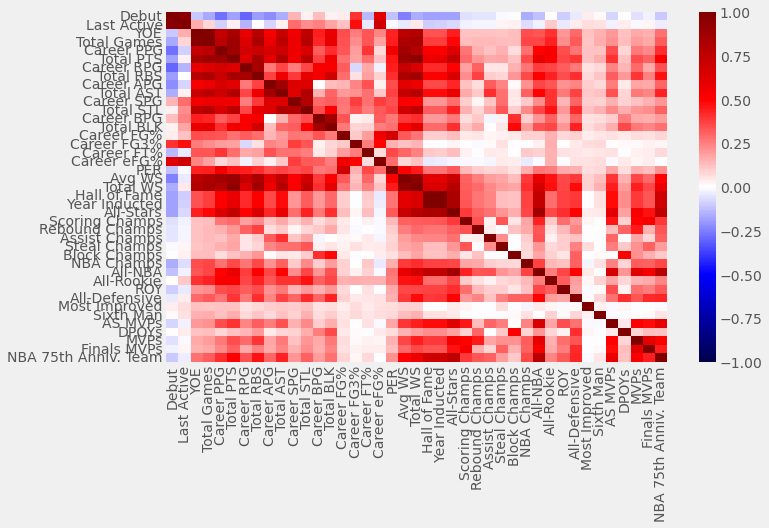

In [17]:
# heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            vmin=-1, vmax=1, cmap='seismic');
plt.show()

In [18]:
# pd.plotting.scatter_matrix(corr, c='b', alpha=0.6, figsize=(15, 10), diagonal='hist');
# plt.show()

In [19]:
#correlation matrix
hof_corr = retired_csv.drop(columns=['Retired','Year Inducted']).corr()['Hall of Fame']
display(hof_corr)

Debut                  -0.149157
Last Active            -0.064425
YOE                     0.333910
Total Games             0.371674
Career PPG              0.501837
Total PTS               0.570240
Career RPG              0.411823
Total RBS               0.504362
Career APG              0.351666
Total AST               0.470663
Career SPG              0.207576
Total STL               0.309200
Career BPG              0.201732
Total BLK               0.286954
Career FG%              0.101187
Career FG3%             0.002064
Career FT%              0.099782
Career eFG%            -0.020563
PER                     0.250434
Avg WS                  0.584681
Total WS                0.625497
Hall of Fame            1.000000
All-Stars               0.810941
Scoring Champs          0.326968
Rebound Champs          0.270707
Assist Champs           0.241844
Steal Champs            0.129620
Block Champs            0.122485
NBA Champs              0.366726
All-NBA                 0.708283
All-Rookie

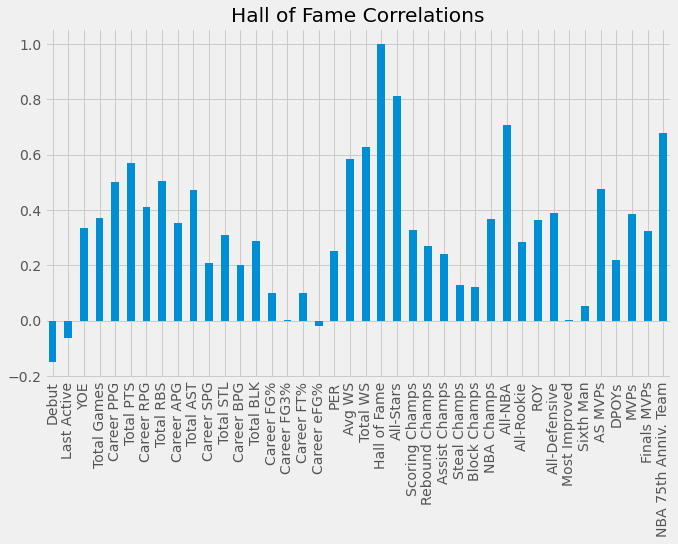

In [20]:
hof_corr.plot.bar()
plt.title('Hall of Fame Correlations')
plt.show()

In [21]:
# we'll also delete Hall of Fame since it directly correlates to itself
remove_key = ['Hall of Fame']

hof_corr_dict = hof_corr.to_dict()
[hof_corr_dict.pop(var) for var in remove_key]

# print(hof_corr_dict)

[1.0]

Lets choose all variables that have a moderate positive correlation; which is anything above 0.30 (nearest 2 decimal points):

In [22]:
predictive_variables = [key for key, value in hof_corr_dict.items() if round(value, 2) >= 0.5]

In [23]:
# hof_elligible = ['Total Games']
# for var in hof_elligible: 
#     if var not in predictive_variables: predictive_variables.append(var)
        
print(predictive_variables, len(predictive_variables))

['Career PPG', 'Total PTS', 'Total RBS', 'Avg WS', 'Total WS', 'All-Stars', 'All-NBA', 'NBA 75th Anniv. Team'] 8


Lets go ahead and do some predictions:

In [24]:
X, y = retired_hof_eligible[predictive_variables], retired_hof_eligible['Hall of Fame']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [26]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2641, 8) (661, 8) (2641,) (661,)


In [27]:
# cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)

In [28]:
# rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)
# for train_index, val_index in rkf.split(X):
#     print("Train:", train_index, "Validation:", val_index)
#     X_train, X_test = X[train_index], X[val_index]
#     y_train, y_test = y[train_index], y[val_index]

# Probabliity Classification

In [29]:
logistic_reg = LogisticRegression().fit(X_train, y_train)

print(metrics.classification_report(y_test, logistic_reg.predict(X_test))); print()
print('Accuracy:', metrics.accuracy_score(y_test, logistic_reg.predict(X_test)))
print('Mean Abs Error: ', metrics.mean_absolute_error(y_test, logistic_reg.predict(X_test)))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, logistic_reg.predict(X_test))); print()
print(metrics.confusion_matrix(y_test, logistic_reg.predict(X_test))); print()
# print(cross_val_score(logistic_reg, X, y, scoring='neg_mean_squared_error', cv=cv))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       638
           1       0.88      0.91      0.89        23

    accuracy                           0.99       661
   macro avg       0.94      0.95      0.94       661
weighted avg       0.99      0.99      0.99       661


Accuracy: 0.9924357034795764
Mean Abs Error:  0.007564296520423601
Mean Squared Error:  0.007564296520423601

[[635   3]
 [  2  21]]



In [30]:
# use platt scaling to calibrate and transform into probablity model
svm_model = svm.SVC(kernel='linear', probability=True).fit(X_train, y_train)

print(metrics.classification_report(y_test, svm_model.predict(X_test))); print()
print('Accuracy:', metrics.accuracy_score(y_test, svm_model.predict(X_test)))
print('Mean Abs Error: ', metrics.mean_absolute_error(y_test, svm_model.predict(X_test)))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, svm_model.predict(X_test))); print()
print(metrics.confusion_matrix(y_test, svm_model.predict(X_test))); print()
# print(cross_val_score(svm_model, X, y, scoring='neg_mean_squared_error', cv=cv))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       638
           1       1.00      0.87      0.93        23

    accuracy                           1.00       661
   macro avg       1.00      0.93      0.96       661
weighted avg       1.00      1.00      1.00       661


Accuracy: 0.9954614220877458
Mean Abs Error:  0.0045385779122541605
Mean Squared Error:  0.0045385779122541605

[[638   0]
 [  3  20]]



In [31]:
bayes = GaussianNB().fit(X_train, y_train)

print(metrics.classification_report(y_test, bayes.predict(X_test))); print()
print('Accuracy: ', metrics.accuracy_score(y_test, bayes.predict(X_test)))
print('Mean Abs Error: ', metrics.mean_absolute_error(y_test, bayes.predict(X_test)))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, bayes.predict(X_test))); print()
print(metrics.confusion_matrix(y_test, bayes.predict(X_test))); print()
# print(cross_val_score(bayes, X, y, scoring='neg_mean_squared_error', cv=10))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       638
           1       0.41      1.00      0.58        23

    accuracy                           0.95       661
   macro avg       0.71      0.97      0.78       661
weighted avg       0.98      0.95      0.96       661


Accuracy:  0.9500756429652042
Mean Abs Error:  0.049924357034795766
Mean Squared Error:  0.049924357034795766

[[605  33]
 [  0  23]]



# Binary Classification

In [32]:
svm_binary = svm.SVC().fit(X_train, y_train)

print(classification_report(y_test, svm_binary.predict(X_test))); print()
print('Accuracy: ', accuracy_score(y_test, svm_binary.predict(X_test)))
print('Mean Abs Error: ', metrics.mean_absolute_error(y_test, svm_binary.predict(X_test)))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, svm_binary.predict(X_test))); print()
print(confusion_matrix(y_test, svm_binary.predict(X_test))); print()
# print(cross_val_score(svm_binary, X, y, cv=10))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       638
           1       0.59      0.43      0.50        23

    accuracy                           0.97       661
   macro avg       0.78      0.71      0.74       661
weighted avg       0.97      0.97      0.97       661


Accuracy:  0.9697428139183056
Mean Abs Error:  0.030257186081694403
Mean Squared Error:  0.030257186081694403

[[631   7]
 [ 13  10]]



In [33]:
decision_tree = tree.DecisionTreeClassifier(max_depth=15).fit(X_train, y_train)

print(classification_report(y_test, decision_tree.predict(X_test))); print()
print('Accuracy: ', accuracy_score(y_test, decision_tree.predict(X_test)))
print('Mean Abs Error: ', metrics.mean_absolute_error(y_test, decision_tree.predict(X_test)))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, decision_tree.predict(X_test))); print()
print(confusion_matrix(y_test, decision_tree.predict(X_test))); print()
# print(cross_val_score(decision_tree, X, y,scoring='neg_mean_squared_error', cv=10))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       638
           1       0.90      0.83      0.86        23

    accuracy                           0.99       661
   macro avg       0.95      0.91      0.93       661
weighted avg       0.99      0.99      0.99       661


Accuracy:  0.9909228441754917
Mean Abs Error:  0.009077155824508321
Mean Squared Error:  0.009077155824508321

[[636   2]
 [  4  19]]



In [34]:
rand_forest = RandomForestClassifier(n_estimators=1000, max_depth=15).fit(X_train, y_train)

print(classification_report(y_test, rand_forest.predict(X_test))); print()
print('Accuracy: ', accuracy_score(y_test, rand_forest.predict(X_test)))
print('Mean Abs Error: ', metrics.mean_absolute_error(y_test, rand_forest.predict(X_test)))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, rand_forest.predict(X_test))); print()
print(confusion_matrix(y_test, rand_forest.predict(X_test))); print()
# print(cross_val_score(rand_forest, X, y, scoring='neg_mean_squared_error',cv=10))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       638
           1       0.95      0.91      0.93        23

    accuracy                           1.00       661
   macro avg       0.98      0.96      0.97       661
weighted avg       1.00      1.00      1.00       661


Accuracy:  0.9954614220877458
Mean Abs Error:  0.0045385779122541605
Mean Squared Error:  0.0045385779122541605

[[637   1]
 [  2  21]]



In [35]:
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

print(classification_report(y_test, knn.predict(X_test))); print()
print('Accuracy: ', accuracy_score(y_test, knn.predict(X_test)))
print('Mean Abs Error: ', metrics.mean_absolute_error(y_test, knn.predict(X_test)))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, knn.predict(X_test))); print()
print(confusion_matrix(y_test, knn.predict(X_test))); print()
# print(cross_val_score(knn, X, y, scoring='neg_mean_squared_error', cv=10))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       638
           1       0.55      0.52      0.53        23

    accuracy                           0.97       661
   macro avg       0.76      0.75      0.76       661
weighted avg       0.97      0.97      0.97       661


Accuracy:  0.9682299546142209
Mean Abs Error:  0.03177004538577912
Mean Squared Error:  0.03177004538577912

[[628  10]
 [ 11  12]]



In [36]:
nba_players_hof_prob = all_nba_players

In [37]:
def set_prob(row):
    player = row[predictive_variables]
    hof_probability = svm_model.predict_proba([player]);
    return hof_probability[0][1]
def set_prob_log(row):
    player = row[predictive_variables]
    hof_probability = logistic_reg.predict_proba([player]);
    return hof_probability[0][1]

In [38]:
def hof_binary(row):
    player = row[predictive_variables]
    hof_binary = rand_forest.predict([player]);
    return hof_binary[0]

In [39]:
show_columns = ['Player','Debut','Last Active','YOE','Position',
                    'Team', 'HOF Probability','HOF (Y/N)','Log']

In [40]:
nba_players_hof_prob['HOF Probability'] = nba_players_hof_prob.apply(lambda row: set_prob(row), axis=1)
nba_players_hof_prob['Log'] = nba_players_hof_prob.apply(lambda row: set_prob_log(row), axis=1)

In [41]:
nba_players_hof_prob['HOF (Y/N)'] = nba_players_hof_prob.apply(lambda row: hof_binary(row), axis=1)

In [42]:
nba_players_hof_prob_to_csv = nba_players_hof_prob[show_columns]

In [43]:
display(nba_players_hof_prob_to_csv)

,Player,Debut,Last Active,YOE,Position,Team,HOF Probability,HOF (Y/N),Log
0,Alaa Abdelnaby,1990,1995,5,PF,POR,0.000335,0,0.001829
1,Zaid Abdul-Aziz,1968,1978,10,C,HOU,0.001248,0,0.000153
2,Kareem Abdul-Jabbar,1969,1989,20,C,LAL,1.000000,1,1.000000
3,Mahmoud Abdul-Rauf,1990,2001,9,PG,DEN,0.002518,0,0.000013
4,Tariq Abdul-Wahad,1997,2003,6,SG,DEN,0.000541,0,0.000237
...,...,...,...,...,...,...,...,...,...
4392,Paul Zipser,2016,2018,2,SF,CHI,0.000208,0,0.002407
4393,Ante Žižić,2017,2020,3,C,CLE,0.000421,0,0.001088
4394,Jim Zoet,1982,1983,1,C,DET,0.000052,0,0.140840
4395,Bill Zopf,1970,1971,1,PG,MIL,0.000094,0,0.024537


In [44]:
nba_players_hof_prob_to_csv.to_csv('csv_files/nba_players_hof_prob.csv', index=False)

In [45]:
hof_players.to_csv('csv_files/hof_players_prob.csv', index=False)

In [46]:
nba_players_hof_prob = nba_players_hof_prob.dropna()

In [47]:
nba_players_hof_prob.to_csv('csv_files/nba_players_hof_prob_with_stats.csv', index=False)

In [48]:
nba_players_hof_prob = pd.read_csv('csv_files/nba_players_hof_prob_with_stats.csv')

In [49]:
last_active = 2018; year_inducted = last_active+4

# predict 2022 hall of fame inductees
hof_prob = nba_players_hof_prob.sort_values(by='HOF Probability', ascending=False)

# get all retired players
retired_non_hof = hof_prob[(hof_prob['Last Active'] <= last_active) &
                                    (hof_prob['Retired'] == 1) &
                                  (hof_prob['Hall of Fame'] == 0) |
                                 (hof_prob['Year Inducted'] == year_inducted) &
                                 (hof_prob['Hall of Fame'] == 1)]

In [50]:
# lets grab the only columns we need
retired_non_hof = retired_non_hof[show_columns]
hof_players_prob = hof_prob[['Player','Debut','Last Active','YOE','Position',
                    'Team', 'HOF Probability','HOF (Y/N)','Year Inducted','Log']]

display(retired_non_hof.head(15))

display(retired_non_hof[retired_non_hof['HOF (Y/N)'] == 1])
print(retired_non_hof.shape)

display(hof_players_prob[hof_players_prob['Year Inducted'] == year_inducted])
print(hof_players.shape)

,Player,Debut,Last Active,YOE,Position,Team,HOF Probability,HOF (Y/N),Log
3548,Amar'e Stoudemire,2002,2016,14,PF,PHO,0.958699,0,0.998721
1191,Larry Foust,1950,1962,12,C,DET,0.947945,0,0.999943
1892,Marques Johnson,1977,1990,11,SF,MIL,0.888788,0,0.637025
837,Brad Daugherty,1986,1994,8,C,CLE,0.847530,0,0.108803
2004,Shawn Kemp,1989,2003,14,PF,OKC,0.804648,0,0.999392
1494,Tim Hardaway,1989,2003,13,PG,GSW,0.789540,1,0.998444
1886,Kevin Johnson,1987,2000,12,PG,PHO,0.687043,0,0.669494
1709,Lou Hudson,1966,1979,13,SG,ATL,0.685235,1,0.879295
298,Chauncey Billups,1997,2014,17,PG,DET,0.652210,0,0.993144
2329,Shawn Marion,1999,2015,16,SF,PHO,0.621613,0,0.719190


,Player,Debut,Last Active,YOE,Position,Team,HOF Probability,HOF (Y/N),Log
1494,Tim Hardaway,1989,2003,13,PG,GSW,0.789540,1,0.998444
1709,Lou Hudson,1966,1979,13,SG,ATL,0.685235,1,0.879295
1311,Manu Ginóbili,2002,2018,16,SG,SAS,0.079629,1,0.120978
4167,Max Zaslofsky,1946,1956,10,SG,CHS,0.065104,1,0.017103


(3175, 9)


,Player,Debut,Last Active,YOE,Position,Team,HOF Probability,HOF (Y/N),Year Inducted,Log
1494,Tim Hardaway,1989,2003,13,PG,GSW,0.789540,1,2022,0.998444
1709,Lou Hudson,1966,1979,13,SG,ATL,0.685235,1,2022,0.879295
1311,Manu Ginóbili,2002,2018,16,SG,SAS,0.079629,1,2022,0.120978


(130, 45)


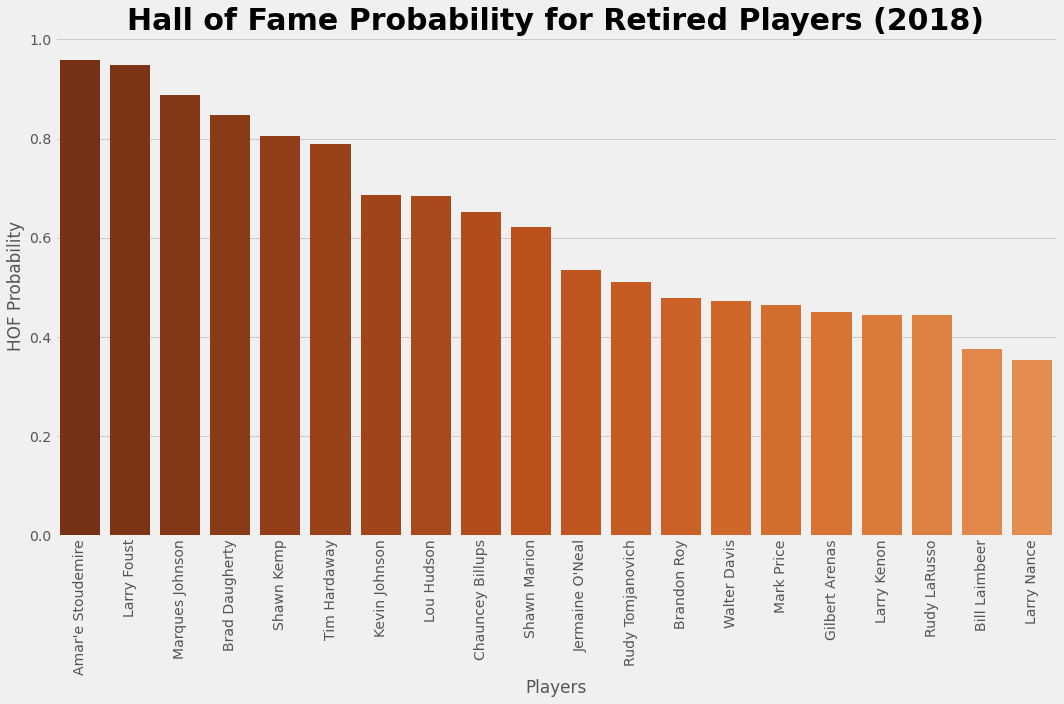

In [59]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,10))

ax = sns.barplot(x='Player', y='HOF Probability', data=retired_non_hof[:20], 
                                             palette=sns.color_palette("Oranges_r", 40))
ax.set_xticklabels(retired_non_hof['Player'][:20], rotation=90)
ax.set(xlabel='Players', ylabel='HOF Probability')
plt.title('Hall of Fame Probability for Retired Players (2018)', fontsize=30, fontweight='bold')

plt.tight_layout()
plt.savefig('images/2022_hof_prob.png')

In [52]:
# predict active inductees
active_players = nba_players_hof_prob.sort_values(by='HOF Probability', ascending=False)

# get all retired players
active_players = active_players[(active_players['Last Active'] == 2022) |
                               (active_players['Retired'] == 0)]

In [53]:
# lets grab the only columns we need
active_players = active_players[show_columns]

display(active_players.head(50))
print(active_players.shape)

,Player,Debut,Last Active,YOE,Position,Team,HOF Probability,HOF (Y/N),Log
1806,LeBron James,2003,2022,19,SF,CLE,1.000000,1,1.000000e+00
1012,Kevin Durant,2007,2022,14,SF,OKC,1.000000,1,1.000000e+00
2885,Chris Paul,2005,2022,17,PG,NOP,1.000000,1,1.000000e+00
1496,James Harden,2009,2022,13,SG,HOU,1.000000,1,1.000000e+00
3937,Russell Westbrook,2008,2022,14,PG,OKC,0.999999,1,1.000000e+00
818,Stephen Curry,2009,2022,13,PG,GSW,0.999998,1,9.999917e-01
842,Anthony Davis,2012,2022,10,PF,NOP,0.999997,1,9.958299e-01
1697,Dwight Howard,2004,2022,18,C,ORL,0.999995,1,1.000000e+00
110,Carmelo Anthony,2003,2022,19,SF,DEN,0.995117,1,1.000000e+00
2213,Damian Lillard,2012,2022,10,PG,POR,0.994509,1,9.961544e-01


(845, 9)


In [54]:
add_cols = ['Hall of Fame', 'Year Inducted']
for col in add_cols: show_columns.append(col)

In [55]:
nba_players_hof_prob = nba_players_hof_prob.sort_values(by='HOF Probability', ascending=False)
display(nba_players_hof_prob[show_columns].head(100))

,Player,Debut,Last Active,YOE,Position,Team,HOF Probability,HOF (Y/N),Log,Hall of Fame,Year Inducted
634,Wilt Chamberlain,1959,1973,14,C,GSW,1.000000,1,1.000000,1,1979
1806,LeBron James,2003,2022,19,SF,CLE,1.000000,1,1.000000,0,0
2,Kareem Abdul-Jabbar,1969,1989,20,C,LAL,1.000000,1,1.000000,1,1995
1005,Tim Duncan,1997,2016,19,C,SAS,1.000000,1,1.000000,1,2020
502,Kobe Bryant,1996,2016,20,SG,LAL,1.000000,1,1.000000,1,2020
2775,Shaquille O'Neal,1992,2011,19,C,LAL,1.000000,1,1.000000,1,2016
1972,Michael Jordan,1984,2003,15,SG,CHI,1.000000,1,1.000000,1,2009
2308,Karl Malone,1985,2004,19,PF,UTA,1.000000,1,1.000000,1,2010
3934,Jerry West,1960,1974,14,PG,LAL,1.000000,1,1.000000,1,1980
3232,Bill Russell,1956,1969,13,C,BOS,1.000000,1,1.000000,1,1975


In [56]:
display(nba_players_hof_prob[show_columns][nba_players_hof_prob['HOF (Y/N)'] == 0].head(25))

,Player,Debut,Last Active,YOE,Position,Team,HOF Probability,HOF (Y/N),Log,Hall of Fame,Year Inducted
3548,Amar'e Stoudemire,2002,2016,14,PF,PHO,0.958699,0,9.987208e-01,0,0
1191,Larry Foust,1950,1962,12,C,DET,0.947945,0,9.999427e-01,0,0
949,Luka Dončić,2018,2022,4,PG,DAL,0.911179,0,2.606138e-06,0,0
1892,Marques Johnson,1977,1990,11,SF,MIL,0.888788,0,6.370250e-01,0,0
837,Brad Daugherty,1986,1994,8,C,CLE,0.847530,0,1.088029e-01,0,0
3712,Karl-Anthony Towns,2015,2022,7,C,MIN,0.845165,0,4.906835e-05,0,0
2004,Shawn Kemp,1989,2003,14,PF,OKC,0.804648,0,9.993916e-01,0,0
1886,Kevin Johnson,1987,2000,12,PG,PHO,0.687043,0,6.694943e-01,0,0
298,Chauncey Billups,1997,2014,17,PG,DET,0.652210,0,9.931435e-01,0,0
2329,Shawn Marion,1999,2015,16,SF,PHO,0.621613,0,7.191899e-01,0,0


In [57]:
# current hall of famers who were not predicted to be in the hall of fame
display(nba_players_hof_prob[show_columns][(nba_players_hof_prob['HOF (Y/N)'] == 0) &
                                   (nba_players_hof_prob['Hall of Fame'] == 1)].head())

# non hall of famers predicted to be the hall of fame
display(nba_players_hof_prob[show_columns][(nba_players_hof_prob['Last Active'] <= 2018) &
                                   (nba_players_hof_prob['HOF (Y/N)'] == 1) &
                                   (nba_players_hof_prob['Hall of Fame'] == 0)].head())

# retired players with the highest probability, but not predicted as hall of famer
display(nba_players_hof_prob[show_columns][(nba_players_hof_prob['Last Active'] <= 2018) &
                                   (nba_players_hof_prob['HOF (Y/N)'] == 0) &
                                   (nba_players_hof_prob['Hall of Fame'] == 0) &
                                   (nba_players_hof_prob['HOF Probability'] >= 0.5)].head())

,Player,Debut,Last Active,YOE,Position,Team,HOF Probability,HOF (Y/N),Log,Hall of Fame,Year Inducted
2252,Clyde Lovellette,1953,1964,11,C,LAL,0.500000,0,0.050619,1,1988
419,Carl Braun,1947,1962,13,PG,NYK,0.285351,0,0.983784,1,2019


,Player,Debut,Last Active,YOE,Position,Team,HOF Probability,HOF (Y/N),Log,Hall of Fame,Year Inducted
4167,Max Zaslofsky,1946,1956,10,SG,CHS,0.065104,1,0.017103,0,0


,Player,Debut,Last Active,YOE,Position,Team,HOF Probability,HOF (Y/N),Log,Hall of Fame,Year Inducted
3548,Amar'e Stoudemire,2002,2016,14,PF,PHO,0.958699,0,0.998721,0,0
1191,Larry Foust,1950,1962,12,C,DET,0.947945,0,0.999943,0,0
1892,Marques Johnson,1977,1990,11,SF,MIL,0.888788,0,0.637025,0,0
837,Brad Daugherty,1986,1994,8,C,CLE,0.847530,0,0.108803,0,0
2004,Shawn Kemp,1989,2003,14,PF,OKC,0.804648,0,0.999392,0,0
